<a href="https://colab.research.google.com/github/violetcfelt/oceanfronts/blob/main/Training_HED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Conv2DTranspose
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint

In [ ]:
def custom_loss(logits, label):
    """
    Implements Equation [2] in https://arxiv.org/pdf/1504.06375.pdf
    """
    y = tf.cast(label, tf.float32)

    count_neg = tf.reduce_sum(1. - y)
    count_pos = tf.reduce_sum(y)

    beta = count_neg / (count_neg + count_pos)

    pos_weight = beta / (1 - beta)

    cost = tf.nn.weighted_cross_entropy_with_logits(logits=logits, labels=y, pos_weight=pos_weight)

    cost = tf.reduce_mean(cost * (1 - beta))

    return cost

def HED():

  vgg = VGG16(input_shape=[224,224,3], weights='imagenet', include_top=False)
  vgg.trainable = False
  input = Input(shape=(224,224,3))
  x = vgg.get_layer('block1_conv1')(input)
  x = vgg.get_layer('block1_conv2')(x)
  side1 = Conv2D(filters=64, kernel_size=3, padding='SAME')(x)
  side1 = Conv2DTranspose(filters=2, kernel_size=3, strides=1, padding='SAME')(side1)
  x = vgg.get_layer('block1_pool')(x)
  x = vgg.get_layer('block2_conv1')(x)
  x = vgg.get_layer('block2_conv2')(x)
  side2 = Conv2D(filters=128, kernel_size=3, padding='SAME')(x)
  side2 = Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding='SAME')(side2)
  x = vgg.get_layer('block2_pool')(x)
  x = vgg.get_layer('block3_conv1')(x)
  x = vgg.get_layer('block3_conv2')(x)
  x = vgg.get_layer('block3_conv3')(x)
  side3 = Conv2D(filters=256, kernel_size=3, padding='SAME')(x)
  side3 = Conv2DTranspose(filters=2, kernel_size=3, strides=4, padding='SAME')(side3)
  x = vgg.get_layer('block3_pool')(x)
  x = vgg.get_layer('block4_conv1')(x)
  x = vgg.get_layer('block4_conv2')(x)
  x = vgg.get_layer('block4_conv3')(x)
  side4 = Conv2D(filters=512, kernel_size=3, padding='SAME')(x)
  side4 = Conv2DTranspose(filters=2, kernel_size=3, strides=8, padding='SAME')(side4)
  x = vgg.get_layer('block4_pool')(x)
  x = vgg.get_layer('block5_conv1')(x)
  x = vgg.get_layer('block5_conv2')(x)
  x = vgg.get_layer('block5_conv3')(x)
  side5 = Conv2D(filters=512, kernel_size=3, padding='SAME')(x)
  side5 = Conv2DTranspose(filters=2, kernel_size=3, strides=16, padding='SAME')(side5)

  side_outputs = [side1, side2, side3, side4, side5]
  output = Conv2D(filters=2, kernel_size=3, padding='SAME', activation='sigmoid')(tf.concat(side_outputs, axis=3))

  model = Model(inputs=input, outputs=output)

  return model


In [ ]:
model = HED()
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[1][0]']           
                                )                                                           

In [ ]:
model.compile(loss=custom_loss) #need the custom loss because of our weird output

In [ ]:
from google.colab import drive
import glob
import numpy as np
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
scene_list = set()
for file in glob.glob("/content/drive/My Drive/east_cropped/*.npy"):
   scene_list.add(file.split('/')[-1].rsplit('_', 1)[0])

print(scene_list)
print(len(scene_list))

{'LC08_014036_20211130', 'LC08_205032_20211007', 'LC08_008030_20170415', 'LC08_011031_20180423', 'LC08_011032_20200311', 'LC08_009030_20190327', 'LC08_012032_20171020', 'LC08_005029_20200520', 'LC08_011030_20180829', 'LC08_014036_20210404', 'LC08_015037_20171025', 'LC08_205033_20210921', 'LC08_013041_20210413', 'LC08_205032_20171028', 'LC08_205052_20201207', 'LC08_008030_20180824', 'LC08_008030_20190405', 'LC08_013033_20190830', 'LC08_012032_20201129', 'LC08_016038_20200126', 'LC08_011032_20210330', 'LC08_005030_20171019', 'LC08_005028_20170731', 'LC08_015037_20180302', 'LC08_205052_20210108', 'LC08_205033_20201121', 'LC08_205052_20180116', 'LC08_208041_20190225', 'LC08_005030_20190806', 'LC08_009030_20200820', 'LC08_011032_20210226', 'LC08_205033_20171028', 'LC08_011032_20180423', 'LC08_205052_20181218', 'LC08_205033_20190324', 'LC08_205052_20191205', 'LC08_012032_20210321', 'LC08_016039_20180309', 'LC08_205052_20170129', 'LC08_208041_20191226', 'LC08_013033_20171027', 'LC08_205032_20

In [ ]:
scene_list = list(scene_list)
X_train = np.empty((len(scene_list),224,224,3),dtype=np.float32)
Y_train = np.empty((len(scene_list),224,224,2),dtype=np.float32)
for scene_num in range(len(scene_list)):
  X_train[scene_num] = np.load('/content/drive/My Drive/east_cropped/' + scene_list[scene_num] + '_input.npy')[:,:,1:4]
  Y_train[scene_num] = np.load('/content/drive/My Drive/east_cropped/' + scene_list[scene_num] + '_output.npy')

In [ ]:
print(Y_train[0][5][0][0])

0.016207993


In [ ]:
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1, save_best_only=True)

history = model.fit(X_train, Y_train, epochs=100, callbacks=[checkpoint])
# model.save_weights('/content/drive/My Drive/trained_weights.h5')
print(history)

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.3622 
Epoch 00001: loss improved from inf to 0.36220, saving model to best_model.hdf5
3/3 [==============================] - 97s 22s/step - loss: 0.3622
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.3645 
Epoch 00002: loss did not improve from 0.36220
3/3 [==============================] - 85s 22s/step - loss: 0.3645
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.3627 
Epoch 00003: loss did not improve from 0.36220
3/3 [==============================] - 82s 22s/step - loss: 0.3627
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 0.3617 
Epoch 00004: loss improved from 0.36220 to 0.36170, saving model to best_model.hdf5
3/3 [==============================] - 83s 22s/step - loss: 0.3617
Epoch 5/100
3/3 [==============================] - ETA: 0s - loss: 0.3309 
Epoch 00005: loss improved from 0.36170 to 0.33090, saving model to best_model.hdf5
3/3 [==========

KeyboardInterrupt: ignored

In [ ]:
print(history.params)

{'verbose': 1, 'epochs': 25, 'steps': 2}


In [ ]:
print(history.history.keys())

dict_keys(['loss'])


In [ ]:
print(history.history['loss'])

[0.3096132278442383, 0.1656474620103836, 0.07818718254566193, 0.00244093406945467, 0.04042873531579971, 0.0015509966760873795, 0.0019418841693550348, 0.025605984032154083, 0.002032968681305647, 0.0010171903995797038, 0.0010769999353215098, 0.0007308431668207049, 4.029367119073868e-05, 2.4122680770233274e-05, 2.0411540390341543e-05, 1.82090461748885e-05, 1.6470839909743518e-05, 1.4938166714273393e-05, 1.3560455954575446e-05, 1.2127452464483213e-05, 9.931731256074272e-06, 4.882707344222581e-06, 2.4785963432805147e-06, 1.7243453385162866e-06, 1.3439500889944611e-06, 1.07341008970252e-06, 9.10563528577768e-07, 7.663498422516568e-07, 6.585956953131245e-07, 5.682373398485652e-07, 5.169077326172555e-07, 4.813848022422462e-07, 4.336783945291245e-07, 3.8380755995603977e-07, 3.565952511053183e-07, 3.2618359568914457e-07, 3.1271110856323503e-07, 2.594748877982056e-07, 2.4830865186231676e-07, 2.2302208435576176e-07, 2.139738910500455e-07, 1.7984517342028994e-07, 1.7195367263411754e-07, 1.646997418

Text(0.5, 1.0, 'Loss During Training')

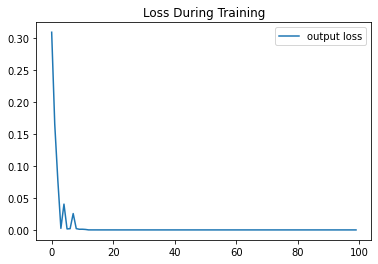

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label = 'output loss')
# plt.plot(history.history['conv2d_transpose_5_loss'], label = 'side loss 1')
# plt.plot(history.history['conv2d_transpose_6_loss'], label = 'side loss 2')
# plt.plot(history.history['conv2d_transpose_7_loss'], label = 'side loss 3')
# plt.plot(history.history['conv2d_transpose_8_loss'], label = 'side loss 4')
# plt.plot(history.history['conv2d_transpose_9_loss'], label = 'side loss 5')
plt.legend()
plt.title('Loss During Training')

Text(0.5, 1.0, 'Accuracy During Training')

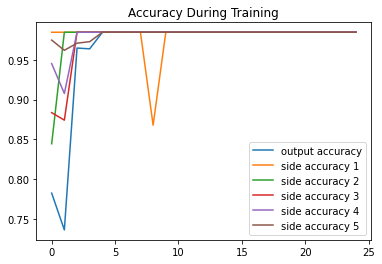

In [ ]:
plt.plot(history.history['conv2d_37_binary_accuracy'], label = 'output accuracy')
plt.plot(history.history['conv2d_transpose_5_binary_accuracy'], label = 'side accuracy 1')
plt.plot(history.history['conv2d_transpose_6_binary_accuracy'], label = 'side accuracy 2')
plt.plot(history.history['conv2d_transpose_7_binary_accuracy'], label = 'side accuracy 3')
plt.plot(history.history['conv2d_transpose_8_binary_accuracy'], label = 'side accuracy 4')
plt.plot(history.history['conv2d_transpose_9_binary_accuracy'], label = 'side accuracy 5')
plt.legend()
plt.title('Accuracy During Training')